<a href="https://colab.research.google.com/github/ArmandDS/bert_for_long_text/blob/master/final_bert_long_docs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Necessary Libraries

In [0]:
import pandas as pd
import numpy as np
np.random.seed(1337)
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking
import numpy as np
import keras
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import datetime
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
import tensorflow as tf
import tensorflow_hub as hub

Using TensorFlow backend.


# Loading The Data

In [0]:
train_raw = pd.read_csv('consumer_complaints.csv')
train_raw.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [0]:
train_raw.shape

(555957, 18)

# Preprocessing Data

Select non null:

In [0]:
train_raw = train_raw[train_raw.consumer_complaint_narrative.notnull()]
train_raw.shape

(66806, 18)

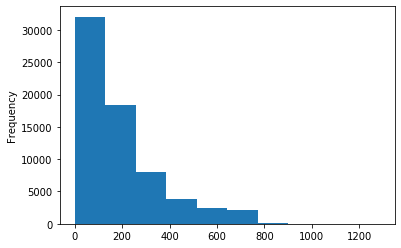

In [0]:
train_raw.consumer_complaint_narrative.apply(lambda x: len(x.split())).plot(kind='hist')

In [0]:
train_raw['len_txt'] =train_raw.consumer_complaint_narrative.apply(lambda x: len(x.split()))
train_raw.describe()

,complaint_id,len_txt
count,6.680600e+04,66806.000000
mean,1.571665e+06,190.644014
std,1.545692e+05,166.830597
min,1.290181e+06,1.000000
25%,1.443264e+06,71.000000
50%,1.569485e+06,136.000000
75%,1.702750e+06,254.000000
max,1.888608e+06,1284.000000


In [0]:
train_raw.shape

(66806, 19)

Select only the row with number of words greater than 250:

In [0]:
train_raw = train_raw[train_raw.len_txt >249]
train_raw.shape

(17142, 19)

In [0]:
train_raw = train_raw[['consumer_complaint_narrative', 'product']]
train_raw.reset_index(inplace=True, drop=True)
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


Group similar products

In [0]:
train_raw.at[train_raw['product'] == 'Credit reporting', 'product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
train_raw.at[train_raw['product'] == 'Credit card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Prepaid card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Payday loan', 'product'] = 'Payday loan, title loan, or personal loan'
train_raw.at[train_raw['product'] == 'Virtual currency', 'product'] = 'Money transfer, virtual currency, or money service'
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [0]:
for l in np.unique(train_raw['product']):
  print(l)

Bank account or service
Consumer Loan
Credit card or prepaid card
Credit reporting, credit repair services, or other personal consumer reports
Debt collection
Money transfers
Mortgage
Other financial service
Payday loan, title loan, or personal loan
Student loan


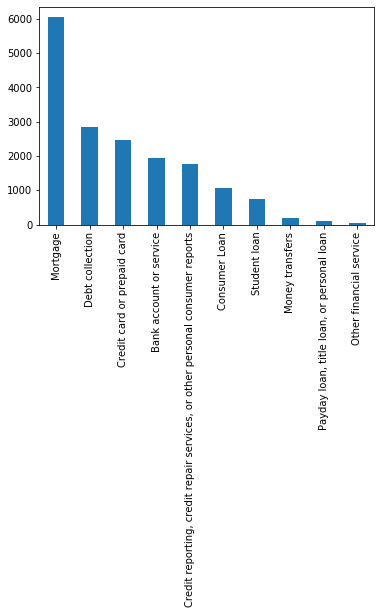

In [0]:
train_raw['product'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [0]:
train_raw=train_raw.rename(columns = {'consumer_complaint_narrative':'text', 'product':'label'})
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [0]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
train_raw['label'] = LE.fit_transform(train_raw['label'])
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,6
1,XXXX was submitted XX/XX/XXXX. At the time I s...,6
2,I spoke to XXXX of green tree representatives ...,6
3,i opened XXXX Bank of America credit cards 15-...,2
4,I applied for a loan with XXXX XXXX and had pu...,1


In [0]:
len(np.unique(train_raw['label']))

10

In [0]:
train = train_raw.copy()

In [0]:
train = train.reindex(np.random.permutation(train.index))
train.head()

,text,label
14660,"XXXX XXXX, XXXX Hyundai of XXXX XXXX XXXX XXXX...",1
15524,"On or about XXXX XXXX, XXXX, the XXXX purchase...",6
9608,On XXXX I became aware that a recently termina...,0
9602,"I recently attempted to obtain a mortgage, at ...",4
11955,Shortly after purchasing my first home I was i...,6


Clean the text columns

In [0]:
import re
def clean_txt(text):
  text = re.sub("'", "",text)
  text=re.sub("(\\W)+"," ",text)    
  return text

In [0]:
train['text']  = train.text.apply(clean_txt)
train.head()

,text,label
14660,XXXX XXXX XXXX Hyundai of XXXX XXXX XXXX XXXX ...,1
15524,On or about XXXX XXXX XXXX the XXXX purchased ...,6
9608,On XXXX I became aware that a recently termina...,0
9602,I recently attempted to obtain a mortgage at w...,4
11955,Shortly after purchasing my first home I was i...,6


In [0]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=35)
train.head()

,text,label
6711,I was sold a Timeshare in XXXX XXXX NJ at the ...,3
13160,I have call and asked this Collection Agency D...,4
16952,XX XX XXXX my debit card information was stole...,0
6908,I have serious questions of the ethical behavi...,3
15676,To whom it may concern I appreciate the email ...,2


In [0]:
train.reset_index(drop=True, inplace=True)
train.head(2)

,text,label
0,I was sold a Timeshare in XXXX XXXX NJ at the ...,3
1,I have call and asked this Collection Agency D...,4


In [0]:
val.reset_index(drop=True, inplace=True)
val.head(2)

,text,label
0,on XXXX XXXX 2015 at XXXX I walked in to Bank ...,0
1,I have been disputing and requesting validatio...,3


In [0]:
val.shape, train.shape

((3429, 2), (13713, 2))

In [0]:
#Installing BERT module
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 2.3MB/s 


In [0]:
#Importing BERT modules
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

# Setting The Output Directory for BERT

In [0]:
# Set the output directory for saving model file
OUTPUT_DIR = '/bert_news_category'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    pass

tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: /bert_news_category *****


In [0]:
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)
# print("Test Set Shape :", test.shape)

Training Set Shape : (13713, 2)
Validation Set Shape : (3429, 2)


In [0]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.label)]
label_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Splitting the Data into smaller chunks

In [0]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200]
      l_total.append(" ".join(l_parcial))
  return l_total

In [0]:
train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head()

,text,label,text_split
0,I was sold a Timeshare in XXXX XXXX NJ at the ...,3,[I was sold a Timeshare in XXXX XXXX NJ at the...
1,I have call and asked this Collection Agency D...,4,[I have call and asked this Collection Agency ...
2,XX XX XXXX my debit card information was stole...,0,[XX XX XXXX my debit card information was stol...
3,I have serious questions of the ethical behavi...,3,[I have serious questions of the ethical behav...
4,To whom it may concern I appreciate the email ...,2,[To whom it may concern I appreciate the email...


In [0]:
val['text_split'] = val[DATA_COLUMN].apply(get_split)
val.head(2)

,text,label,text_split
0,on XXXX XXXX 2015 at XXXX I walked in to Bank ...,0,[on XXXX XXXX 2015 at XXXX I walked in to Bank...
1,I have been disputing and requesting validatio...,3,[I have been disputing and requesting validati...


In [0]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(31679, 31679, 31679)

In [0]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(7946, 7946, 7946)

The final dataset for training:

In [0]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,text,label
0,I was sold a Timeshare in XXXX XXXX NJ at the ...,3
1,unless they could prove to me any sort of valu...,3
2,I have call and asked this Collection Agency D...,4
3,XX XX XXXX my debit card information was stole...,0
4,I have serious questions of the ethical behavi...,3


In [0]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label
0,on XXXX XXXX 2015 at XXXX I walked in to Bank ...,0
1,for her to train because I know they do nt nee...,0
2,I have been disputing and requesting validatio...,3
3,the right to request validation of the debt yo...,3
4,My complaint is against the credit bureau Equi...,3


# BERT: Data Preprocessing 

Process the data for BERT

In [0]:
train_InputExamples = train_df.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

val_InputExamples = val_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [0]:
train_InputExamples

0        <bert.run_classifier.InputExample object at 0x...
1        <bert.run_classifier.InputExample object at 0x...
2        <bert.run_classifier.InputExample object at 0x...
3        <bert.run_classifier.InputExample object at 0x...
4        <bert.run_classifier.InputExample object at 0x...
                               ...                        
31674    <bert.run_classifier.InputExample object at 0x...
31675    <bert.run_classifier.InputExample object at 0x...
31676    <bert.run_classifier.InputExample object at 0x...
31677    <bert.run_classifier.InputExample object at 0x...
31678    <bert.run_classifier.InputExample object at 0x...
Length: 31679, dtype: object

In [0]:
print("Row 0 - guid of training set : ", train_InputExamples.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  I was sold a Timeshare in XXXX XXXX NJ at the XXXX XXXX through a company doing business as XXXX Subsequent to the agreement I had an issue where my wife took ill and needed surgery Since she is the primary income provider I found myself unable to meet all of my obligations I determined the Timeshare was an unneeded expense so they were not paid They started harassing me I looked into this whole timeshare issue and found out that my membership was nothing more than a source of income for the Hotel that if I were to simply reserve a room through the Internet at the exact same location it would cost me less than HALF what I pay annually in Maintenance fees and taxes When they called back after I discovered this I informed them that I was misled and refused to pay any more into this unless they could prove to me any sort of value in what I purchased They have since then threatened me with legal action inclu

# BERT: Loading the pre-trained model

In [0]:

# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [0]:
len(tokenizer.vocab.keys())

30522

In [0]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['i', 'was', 'sold', 'a', 'times', '##har', '##e', 'in', 'xx', '##xx', 'xx', '##xx', 'nj', 'at', 'the', 'xx', '##xx', 'xx', '##xx', 'through', 'a', 'company', 'doing', 'business', 'as', 'xx', '##xx', 'subsequent', 'to', 'the', 'agreement', 'i', 'had', 'an', 'issue', 'where', 'my', 'wife', 'took', 'ill', 'and', 'needed', 'surgery', 'since', 'she', 'is', 'the', 'primary', 'income', 'provider', 'i', 'found', 'myself', 'unable', 'to', 'meet', 'all', 'of', 'my', 'obligations', 'i', 'determined', 'the', 'times', '##har', '##e', 'was', 'an', 'un', '##nee', '##ded', 'expense', 'so', 'they', 'were', 'not', 'paid', 'they', 'started', 'hara', '##ssing', 'me', 'i', 'looked', 'into', 'this', 'whole', 'times', '##har', '##e', 'issue', 'and', 'found', 'out', 'that', 'my', 'membership', 'was', 'nothing', 'more', 'than', 'a', 'source', 'of', 'income', 'for', 'the', 'hotel', 'that', 'if', 'i', 'were', 'to', 'simply', 'reserve', 'a', 'room', 'through', 'the', 'internet', 'at', 'the', 'exact', 'same', 'lo

In [0]:
MAX_SEQ_LENGTH = 200

In [0]:
# Convert our train and validation features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

val_features = bert.run_classifier.convert_examples_to_features(val_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 31679


INFO:tensorflow:Writing example 0 of 31679


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i was sold a times ##har ##e in xx ##xx xx ##xx nj at the xx ##xx xx ##xx through a company doing business as xx ##xx subsequent to the agreement i had an issue where my wife took ill and needed surgery since she is the primary income provider i found myself unable to meet all of my obligations i determined the times ##har ##e was an un ##nee ##ded expense so they were not paid they started hara ##ssing me i looked into this whole times ##har ##e issue and found out that my membership was nothing more than a source of income for the hotel that if i were to simply reserve a room through the internet at the exact same location it would cost me less than half what i pay annually in maintenance fees and taxes when they called back after i discovered this i informed them that i was mis ##led and refused to pay any more into this unless they could prove to me any sort of value in what i purchased they have since then threatened me with legal action including che

INFO:tensorflow:tokens: [CLS] i was sold a times ##har ##e in xx ##xx xx ##xx nj at the xx ##xx xx ##xx through a company doing business as xx ##xx subsequent to the agreement i had an issue where my wife took ill and needed surgery since she is the primary income provider i found myself unable to meet all of my obligations i determined the times ##har ##e was an un ##nee ##ded expense so they were not paid they started hara ##ssing me i looked into this whole times ##har ##e issue and found out that my membership was nothing more than a source of income for the hotel that if i were to simply reserve a room through the internet at the exact same location it would cost me less than half what i pay annually in maintenance fees and taxes when they called back after i discovered this i informed them that i was mis ##led and refused to pay any more into this unless they could prove to me any sort of value in what i purchased they have since then threatened me with legal action including che

INFO:tensorflow:input_ids: 101 1045 2001 2853 1037 2335 8167 2063 1999 22038 20348 22038 20348 19193 2012 1996 22038 20348 22038 20348 2083 1037 2194 2725 2449 2004 22038 20348 4745 2000 1996 3820 1045 2018 2019 3277 2073 2026 2564 2165 5665 1998 2734 5970 2144 2016 2003 1996 3078 3318 10802 1045 2179 2870 4039 2000 3113 2035 1997 2026 14422 1045 4340 1996 2335 8167 2063 2001 2019 4895 24045 5732 10961 2061 2027 2020 2025 3825 2027 2318 18820 18965 2033 1045 2246 2046 2023 2878 2335 8167 2063 3277 1998 2179 2041 2008 2026 5779 2001 2498 2062 2084 1037 3120 1997 3318 2005 1996 3309 2008 2065 1045 2020 2000 3432 3914 1037 2282 2083 1996 4274 2012 1996 6635 2168 3295 2009 2052 3465 2033 2625 2084 2431 2054 1045 3477 6604 1999 6032 9883 1998 7773 2043 2027 2170 2067 2044 1045 3603 2023 1045 6727 2068 2008 1045 2001 28616 3709 1998 4188 2000 3477 2151 2062 2046 2023 4983 2027 2071 6011 2000 2033 2151 4066 1997 3643 1999 2054 1045 4156 2027 2031 2144 2059 5561 2033 2007 3423 2895 2164 4638 9

INFO:tensorflow:input_ids: 101 1045 2001 2853 1037 2335 8167 2063 1999 22038 20348 22038 20348 19193 2012 1996 22038 20348 22038 20348 2083 1037 2194 2725 2449 2004 22038 20348 4745 2000 1996 3820 1045 2018 2019 3277 2073 2026 2564 2165 5665 1998 2734 5970 2144 2016 2003 1996 3078 3318 10802 1045 2179 2870 4039 2000 3113 2035 1997 2026 14422 1045 4340 1996 2335 8167 2063 2001 2019 4895 24045 5732 10961 2061 2027 2020 2025 3825 2027 2318 18820 18965 2033 1045 2246 2046 2023 2878 2335 8167 2063 3277 1998 2179 2041 2008 2026 5779 2001 2498 2062 2084 1037 3120 1997 3318 2005 1996 3309 2008 2065 1045 2020 2000 3432 3914 1037 2282 2083 1996 4274 2012 1996 6635 2168 3295 2009 2052 3465 2033 2625 2084 2431 2054 1045 3477 6604 1999 6032 9883 1998 7773 2043 2027 2170 2067 2044 1045 3603 2023 1045 6727 2068 2008 1045 2001 28616 3709 1998 4188 2000 3477 2151 2062 2046 2023 4983 2027 2071 6011 2000 2033 2151 4066 1997 3643 1999 2054 1045 4156 2027 2031 2144 2059 5561 2033 2007 3423 2895 2164 4638 9

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] unless they could prove to me any sort of value in what i purchased they have since then threatened me with legal action including check fraud and when i informed them that their threats were in fact a violation of the fair debt collection act they stopped the calls but now have started doing hard inquiries into my credit xx ##xx on xx ##xx xx ##xx 2015 and the latest on xx ##xx xx ##xx 2015 i called trans ##uni ##on and they informed me that the only way to get these unauthorized inquiries removed was to contact xx ##xx in writing and ask them to allow the inquiries to be removed i find this totally unfair and as i understand illegal as i have not authorized these multiple inquiries into my credit and as a result have suffered a xx ##xx point drop in my credit score i ask for your assistance in getting this unfair practice stopped and that xx ##xx be ordered to cease and des ##ist from these practices this is nothing more than a sc ##am in my opinion and 

INFO:tensorflow:tokens: [CLS] unless they could prove to me any sort of value in what i purchased they have since then threatened me with legal action including check fraud and when i informed them that their threats were in fact a violation of the fair debt collection act they stopped the calls but now have started doing hard inquiries into my credit xx ##xx on xx ##xx xx ##xx 2015 and the latest on xx ##xx xx ##xx 2015 i called trans ##uni ##on and they informed me that the only way to get these unauthorized inquiries removed was to contact xx ##xx in writing and ask them to allow the inquiries to be removed i find this totally unfair and as i understand illegal as i have not authorized these multiple inquiries into my credit and as a result have suffered a xx ##xx point drop in my credit score i ask for your assistance in getting this unfair practice stopped and that xx ##xx be ordered to cease and des ##ist from these practices this is nothing more than a sc ##am in my opinion and 

INFO:tensorflow:input_ids: 101 4983 2027 2071 6011 2000 2033 2151 4066 1997 3643 1999 2054 1045 4156 2027 2031 2144 2059 5561 2033 2007 3423 2895 2164 4638 9861 1998 2043 1045 6727 2068 2008 2037 8767 2020 1999 2755 1037 11371 1997 1996 4189 7016 3074 2552 2027 3030 1996 4455 2021 2085 2031 2318 2725 2524 27050 2046 2026 4923 22038 20348 2006 22038 20348 22038 20348 2325 1998 1996 6745 2006 22038 20348 22038 20348 2325 1045 2170 9099 19496 2239 1998 2027 6727 2033 2008 1996 2069 2126 2000 2131 2122 24641 27050 3718 2001 2000 3967 22038 20348 1999 3015 1998 3198 2068 2000 3499 1996 27050 2000 2022 3718 1045 2424 2023 6135 15571 1998 2004 1045 3305 6206 2004 1045 2031 2025 9362 2122 3674 27050 2046 2026 4923 1998 2004 1037 2765 2031 4265 1037 22038 20348 2391 4530 1999 2026 4923 3556 1045 3198 2005 2115 5375 1999 2893 2023 15571 3218 3030 1998 2008 22038 20348 2022 3641 2000 13236 1998 4078 2923 2013 2122 6078 2023 2003 2498 2062 2084 1037 8040 3286 1999 2026 5448 1998 2037 27891 1997 21

INFO:tensorflow:input_ids: 101 4983 2027 2071 6011 2000 2033 2151 4066 1997 3643 1999 2054 1045 4156 2027 2031 2144 2059 5561 2033 2007 3423 2895 2164 4638 9861 1998 2043 1045 6727 2068 2008 2037 8767 2020 1999 2755 1037 11371 1997 1996 4189 7016 3074 2552 2027 3030 1996 4455 2021 2085 2031 2318 2725 2524 27050 2046 2026 4923 22038 20348 2006 22038 20348 22038 20348 2325 1998 1996 6745 2006 22038 20348 22038 20348 2325 1045 2170 9099 19496 2239 1998 2027 6727 2033 2008 1996 2069 2126 2000 2131 2122 24641 27050 3718 2001 2000 3967 22038 20348 1999 3015 1998 3198 2068 2000 3499 1996 27050 2000 2022 3718 1045 2424 2023 6135 15571 1998 2004 1045 3305 6206 2004 1045 2031 2025 9362 2122 3674 27050 2046 2026 4923 1998 2004 1037 2765 2031 4265 1037 22038 20348 2391 4530 1999 2026 4923 3556 1045 3198 2005 2115 5375 1999 2893 2023 15571 3218 3030 1998 2008 22038 20348 2022 3641 2000 13236 1998 4078 2923 2013 2122 6078 2023 2003 2498 2062 2084 1037 8040 3286 1999 2026 5448 1998 2037 27891 1997 21

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i have call and asked this collection agency diversified consultant to remove a collection of 170 00 from xx ##xx xx ##xx xx ##xx they claim they have the authority to collect the first time i called they could nt find that i owed a debt and the second time i called they told me that they had an account but my social security number did nt match the xx ##xx they had on the account this is not my debt i have never had any type of service with xx ##xx xx ##xx xx ##xx i asked for a verification of the debt and ended up talking with a supervisor named xx ##xx xx ##xx direct phone xx ##xx xx ##xx was very helpful and informed me that the social security associated with this collection account was different than mine he said they would remove del ##ete this collection from all xx ##xx of the credit reporting agencies xx ##xx xx ##xx and xx ##xx xx ##xx if i would fa ##x them some information he instructed me to fa ##x front page of my credit report and the page 

INFO:tensorflow:tokens: [CLS] i have call and asked this collection agency diversified consultant to remove a collection of 170 00 from xx ##xx xx ##xx xx ##xx they claim they have the authority to collect the first time i called they could nt find that i owed a debt and the second time i called they told me that they had an account but my social security number did nt match the xx ##xx they had on the account this is not my debt i have never had any type of service with xx ##xx xx ##xx xx ##xx i asked for a verification of the debt and ended up talking with a supervisor named xx ##xx xx ##xx direct phone xx ##xx xx ##xx was very helpful and informed me that the social security associated with this collection account was different than mine he said they would remove del ##ete this collection from all xx ##xx of the credit reporting agencies xx ##xx xx ##xx and xx ##xx xx ##xx if i would fa ##x them some information he instructed me to fa ##x front page of my credit report and the page 

INFO:tensorflow:input_ids: 101 1045 2031 2655 1998 2356 2023 3074 4034 24908 8930 2000 6366 1037 3074 1997 10894 4002 2013 22038 20348 22038 20348 22038 20348 2027 4366 2027 2031 1996 3691 2000 8145 1996 2034 2051 1045 2170 2027 2071 23961 2424 2008 1045 12232 1037 7016 1998 1996 2117 2051 1045 2170 2027 2409 2033 2008 2027 2018 2019 4070 2021 2026 2591 3036 2193 2106 23961 2674 1996 22038 20348 2027 2018 2006 1996 4070 2023 2003 2025 2026 7016 1045 2031 2196 2018 2151 2828 1997 2326 2007 22038 20348 22038 20348 22038 20348 1045 2356 2005 1037 22616 1997 1996 7016 1998 3092 2039 3331 2007 1037 12366 2315 22038 20348 22038 20348 3622 3042 22038 20348 22038 20348 2001 2200 14044 1998 6727 2033 2008 1996 2591 3036 3378 2007 2023 3074 4070 2001 2367 2084 3067 2002 2056 2027 2052 6366 3972 12870 2023 3074 2013 2035 22038 20348 1997 1996 4923 7316 6736 22038 20348 22038 20348 1998 22038 20348 22038 20348 2065 1045 2052 6904 2595 2068 2070 2592 2002 10290 2033 2000 6904 2595 2392 3931 1997 20

INFO:tensorflow:input_ids: 101 1045 2031 2655 1998 2356 2023 3074 4034 24908 8930 2000 6366 1037 3074 1997 10894 4002 2013 22038 20348 22038 20348 22038 20348 2027 4366 2027 2031 1996 3691 2000 8145 1996 2034 2051 1045 2170 2027 2071 23961 2424 2008 1045 12232 1037 7016 1998 1996 2117 2051 1045 2170 2027 2409 2033 2008 2027 2018 2019 4070 2021 2026 2591 3036 2193 2106 23961 2674 1996 22038 20348 2027 2018 2006 1996 4070 2023 2003 2025 2026 7016 1045 2031 2196 2018 2151 2828 1997 2326 2007 22038 20348 22038 20348 22038 20348 1045 2356 2005 1037 22616 1997 1996 7016 1998 3092 2039 3331 2007 1037 12366 2315 22038 20348 22038 20348 3622 3042 22038 20348 22038 20348 2001 2200 14044 1998 6727 2033 2008 1996 2591 3036 3378 2007 2023 3074 4070 2001 2367 2084 3067 2002 2056 2027 2052 6366 3972 12870 2023 3074 2013 2035 22038 20348 1997 1996 4923 7316 6736 22038 20348 22038 20348 1998 22038 20348 22038 20348 2065 1045 2052 6904 2595 2068 2070 2592 2002 10290 2033 2000 6904 2595 2392 3931 1997 20

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:label: 4 (id = 4)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] xx xx xx ##xx my de ##bit card information was stolen and someone rack ##ed up about 2000 00 worth of charges on my ci ##ti ##bank checking account when i went into the bank and explained my situation to the banker they told me they would investigate and my money would be ref ##und ##ed within 7 to 10 days i went back to the bank weeks later and still no ref ##und i spoke with a representative from ci ##ti ##bank and she told me they sent me a letter in the mail that i never received that stated they were denying my claim and were nt going to ref ##und my money to my account because it appears i rack ##ed up charges myself she told me i needed to file a police report and there s nothing she can do so i filed my police report like she told me with an officer named xx ##xx xx ##xx in his report he states that he received sur ##va ##ila ##nce from one of the atm s i had claimed to never been to before and found that somebody else was in fact at the [SEP]


INFO:tensorflow:tokens: [CLS] xx xx xx ##xx my de ##bit card information was stolen and someone rack ##ed up about 2000 00 worth of charges on my ci ##ti ##bank checking account when i went into the bank and explained my situation to the banker they told me they would investigate and my money would be ref ##und ##ed within 7 to 10 days i went back to the bank weeks later and still no ref ##und i spoke with a representative from ci ##ti ##bank and she told me they sent me a letter in the mail that i never received that stated they were denying my claim and were nt going to ref ##und my money to my account because it appears i rack ##ed up charges myself she told me i needed to file a police report and there s nothing she can do so i filed my police report like she told me with an officer named xx ##xx xx ##xx in his report he states that he received sur ##va ##ila ##nce from one of the atm s i had claimed to never been to before and found that somebody else was in fact at the [SEP]


INFO:tensorflow:input_ids: 101 22038 22038 22038 20348 2026 2139 16313 4003 2592 2001 7376 1998 2619 14513 2098 2039 2055 2456 4002 4276 1997 5571 2006 2026 25022 3775 9299 9361 4070 2043 1045 2253 2046 1996 2924 1998 4541 2026 3663 2000 1996 13448 2027 2409 2033 2027 2052 8556 1998 2026 2769 2052 2022 25416 8630 2098 2306 1021 2000 2184 2420 1045 2253 2067 2000 1996 2924 3134 2101 1998 2145 2053 25416 8630 1045 3764 2007 1037 4387 2013 25022 3775 9299 1998 2016 2409 2033 2027 2741 2033 1037 3661 1999 1996 5653 2008 1045 2196 2363 2008 3090 2027 2020 16039 2026 4366 1998 2020 23961 2183 2000 25416 8630 2026 2769 2000 2026 4070 2138 2009 3544 1045 14513 2098 2039 5571 2870 2016 2409 2033 1045 2734 2000 5371 1037 2610 3189 1998 2045 1055 2498 2016 2064 2079 2061 1045 6406 2026 2610 3189 2066 2016 2409 2033 2007 2019 2961 2315 22038 20348 22038 20348 1999 2010 3189 2002 2163 2008 2002 2363 7505 3567 11733 5897 2013 2028 1997 1996 27218 1055 1045 2018 3555 2000 2196 2042 2000 2077 1998 217

INFO:tensorflow:input_ids: 101 22038 22038 22038 20348 2026 2139 16313 4003 2592 2001 7376 1998 2619 14513 2098 2039 2055 2456 4002 4276 1997 5571 2006 2026 25022 3775 9299 9361 4070 2043 1045 2253 2046 1996 2924 1998 4541 2026 3663 2000 1996 13448 2027 2409 2033 2027 2052 8556 1998 2026 2769 2052 2022 25416 8630 2098 2306 1021 2000 2184 2420 1045 2253 2067 2000 1996 2924 3134 2101 1998 2145 2053 25416 8630 1045 3764 2007 1037 4387 2013 25022 3775 9299 1998 2016 2409 2033 2027 2741 2033 1037 3661 1999 1996 5653 2008 1045 2196 2363 2008 3090 2027 2020 16039 2026 4366 1998 2020 23961 2183 2000 25416 8630 2026 2769 2000 2026 4070 2138 2009 3544 1045 14513 2098 2039 5571 2870 2016 2409 2033 1045 2734 2000 5371 1037 2610 3189 1998 2045 1055 2498 2016 2064 2079 2061 1045 6406 2026 2610 3189 2066 2016 2409 2033 2007 2019 2961 2315 22038 20348 22038 20348 1999 2010 3189 2002 2163 2008 2002 2363 7505 3567 11733 5897 2013 2028 1997 1996 27218 1055 1045 2018 3555 2000 2196 2042 2000 2077 1998 217

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i have serious questions of the ethical behaviour of ex ##per ##ian in relation to what credit score they report they report on an individual depend ##ant upon whether the individual requesting the credit report is paying for the premium xx ##xx agency report or whether they choose to use a free service provided through their bank or other financial institution xx ##xx in this case where they en ##tic ##e you to enroll in the other xx ##xx agency premium credit report and protection i am going to provide xx ##xx separate ex ##per ##ian credit reports that were pulled within minutes of each other both pu ##rp ##ort ##ing to show my credit score however instead of matching as xx ##xx would expect them to the paid ex ##per ##ian xx ##xx agency report that was signed up for through xx ##xx xx ##xx xx ##xx shows my score to be xx ##xx yet when the free credit score monitoring service provided by ex ##per ##ian for xx ##xx is pulled within minutes and the credit

INFO:tensorflow:tokens: [CLS] i have serious questions of the ethical behaviour of ex ##per ##ian in relation to what credit score they report they report on an individual depend ##ant upon whether the individual requesting the credit report is paying for the premium xx ##xx agency report or whether they choose to use a free service provided through their bank or other financial institution xx ##xx in this case where they en ##tic ##e you to enroll in the other xx ##xx agency premium credit report and protection i am going to provide xx ##xx separate ex ##per ##ian credit reports that were pulled within minutes of each other both pu ##rp ##ort ##ing to show my credit score however instead of matching as xx ##xx would expect them to the paid ex ##per ##ian xx ##xx agency report that was signed up for through xx ##xx xx ##xx xx ##xx shows my score to be xx ##xx yet when the free credit score monitoring service provided by ex ##per ##ian for xx ##xx is pulled within minutes and the credit

INFO:tensorflow:input_ids: 101 1045 2031 3809 3980 1997 1996 12962 9164 1997 4654 4842 2937 1999 7189 2000 2054 4923 3556 2027 3189 2027 3189 2006 2019 3265 12530 4630 2588 3251 1996 3265 17942 1996 4923 3189 2003 7079 2005 1996 12882 22038 20348 4034 3189 2030 3251 2027 5454 2000 2224 1037 2489 2326 3024 2083 2037 2924 2030 2060 3361 5145 22038 20348 1999 2023 2553 2073 2027 4372 4588 2063 2017 2000 25612 1999 1996 2060 22038 20348 4034 12882 4923 3189 1998 3860 1045 2572 2183 2000 3073 22038 20348 3584 4654 4842 2937 4923 4311 2008 2020 2766 2306 2781 1997 2169 2060 2119 16405 14536 11589 2075 2000 2265 2026 4923 3556 2174 2612 1997 9844 2004 22038 20348 2052 5987 2068 2000 1996 3825 4654 4842 2937 22038 20348 4034 3189 2008 2001 2772 2039 2005 2083 22038 20348 22038 20348 22038 20348 3065 2026 3556 2000 2022 22038 20348 2664 2043 1996 2489 4923 3556 8822 2326 3024 2011 4654 4842 2937 2005 22038 20348 2003 2766 2306 2781 1998 1996 4923 3189 3065 2053 3430 5966 2009 4311 2008 2026 492

INFO:tensorflow:input_ids: 101 1045 2031 3809 3980 1997 1996 12962 9164 1997 4654 4842 2937 1999 7189 2000 2054 4923 3556 2027 3189 2027 3189 2006 2019 3265 12530 4630 2588 3251 1996 3265 17942 1996 4923 3189 2003 7079 2005 1996 12882 22038 20348 4034 3189 2030 3251 2027 5454 2000 2224 1037 2489 2326 3024 2083 2037 2924 2030 2060 3361 5145 22038 20348 1999 2023 2553 2073 2027 4372 4588 2063 2017 2000 25612 1999 1996 2060 22038 20348 4034 12882 4923 3189 1998 3860 1045 2572 2183 2000 3073 22038 20348 3584 4654 4842 2937 4923 4311 2008 2020 2766 2306 2781 1997 2169 2060 2119 16405 14536 11589 2075 2000 2265 2026 4923 3556 2174 2612 1997 9844 2004 22038 20348 2052 5987 2068 2000 1996 3825 4654 4842 2937 22038 20348 4034 3189 2008 2001 2772 2039 2005 2083 22038 20348 22038 20348 22038 20348 3065 2026 3556 2000 2022 22038 20348 2664 2043 1996 2489 4923 3556 8822 2326 3024 2011 4654 4842 2937 2005 22038 20348 2003 2766 2306 2781 1998 1996 4923 3189 3065 2053 3430 5966 2009 4311 2008 2026 492

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:Writing example 10000 of 31679


INFO:tensorflow:Writing example 10000 of 31679


INFO:tensorflow:Writing example 20000 of 31679


INFO:tensorflow:Writing example 20000 of 31679


INFO:tensorflow:Writing example 30000 of 31679


INFO:tensorflow:Writing example 30000 of 31679


INFO:tensorflow:Writing example 0 of 7946


INFO:tensorflow:Writing example 0 of 7946


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] on xx ##xx xx ##xx 2015 at xx ##xx i walked in to bank of america in xx ##xx xx ##xx xx ##xx xx ##xx tn xx ##xx to deposit cash more than 10 00 that in business require to fill up ct ##r form that i have already did since i ve been customer for many years everything went well until up to that form pop out on the cash ##iers screen it took her 10 minutes trying to figure out the way out then finally called manager that does nt know how to do that either then called another senior cash ##ier cash ##iers manager to help out they chat for a while then she left but this cash ##ier still seems did nt know and still try and try 20 minutes has passed i told her if i can get my dl back she can make a copy of it if she needs to but do nt hold me there for her to train because i know they do nt need me there at all but she refused to give my dl back or make any note just keep trying few more minutes passed i [SEP]


INFO:tensorflow:tokens: [CLS] on xx ##xx xx ##xx 2015 at xx ##xx i walked in to bank of america in xx ##xx xx ##xx xx ##xx xx ##xx tn xx ##xx to deposit cash more than 10 00 that in business require to fill up ct ##r form that i have already did since i ve been customer for many years everything went well until up to that form pop out on the cash ##iers screen it took her 10 minutes trying to figure out the way out then finally called manager that does nt know how to do that either then called another senior cash ##ier cash ##iers manager to help out they chat for a while then she left but this cash ##ier still seems did nt know and still try and try 20 minutes has passed i told her if i can get my dl back she can make a copy of it if she needs to but do nt hold me there for her to train because i know they do nt need me there at all but she refused to give my dl back or make any note just keep trying few more minutes passed i [SEP]


INFO:tensorflow:input_ids: 101 2006 22038 20348 22038 20348 2325 2012 22038 20348 1045 2939 1999 2000 2924 1997 2637 1999 22038 20348 22038 20348 22038 20348 22038 20348 28286 22038 20348 2000 12816 5356 2062 2084 2184 4002 2008 1999 2449 5478 2000 6039 2039 14931 2099 2433 2008 1045 2031 2525 2106 2144 1045 2310 2042 8013 2005 2116 2086 2673 2253 2092 2127 2039 2000 2008 2433 3769 2041 2006 1996 5356 10136 3898 2009 2165 2014 2184 2781 2667 2000 3275 2041 1996 2126 2041 2059 2633 2170 3208 2008 2515 23961 2113 2129 2000 2079 2008 2593 2059 2170 2178 3026 5356 3771 5356 10136 3208 2000 2393 2041 2027 11834 2005 1037 2096 2059 2016 2187 2021 2023 5356 3771 2145 3849 2106 23961 2113 1998 2145 3046 1998 3046 2322 2781 2038 2979 1045 2409 2014 2065 1045 2064 2131 2026 21469 2067 2016 2064 2191 1037 6100 1997 2009 2065 2016 3791 2000 2021 2079 23961 2907 2033 2045 2005 2014 2000 3345 2138 1045 2113 2027 2079 23961 2342 2033 2045 2012 2035 2021 2016 4188 2000 2507 2026 21469 2067 2030 2191 2

INFO:tensorflow:input_ids: 101 2006 22038 20348 22038 20348 2325 2012 22038 20348 1045 2939 1999 2000 2924 1997 2637 1999 22038 20348 22038 20348 22038 20348 22038 20348 28286 22038 20348 2000 12816 5356 2062 2084 2184 4002 2008 1999 2449 5478 2000 6039 2039 14931 2099 2433 2008 1045 2031 2525 2106 2144 1045 2310 2042 8013 2005 2116 2086 2673 2253 2092 2127 2039 2000 2008 2433 3769 2041 2006 1996 5356 10136 3898 2009 2165 2014 2184 2781 2667 2000 3275 2041 1996 2126 2041 2059 2633 2170 3208 2008 2515 23961 2113 2129 2000 2079 2008 2593 2059 2170 2178 3026 5356 3771 5356 10136 3208 2000 2393 2041 2027 11834 2005 1037 2096 2059 2016 2187 2021 2023 5356 3771 2145 3849 2106 23961 2113 1998 2145 3046 1998 3046 2322 2781 2038 2979 1045 2409 2014 2065 1045 2064 2131 2026 21469 2067 2016 2064 2191 1037 6100 1997 2009 2065 2016 3791 2000 2021 2079 23961 2907 2033 2045 2005 2014 2000 3345 2138 1045 2113 2027 2079 23961 2342 2033 2045 2012 2035 2021 2016 4188 2000 2507 2026 21469 2067 2030 2191 2

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] for her to train because i know they do nt need me there at all but she refused to give my dl back or make any note just keep trying few more minutes passed i asked one more time and she refused then i tried to grab my dl but she took it faster and step back i was furious then i grab her hand try to pull her so i can get my dl but she still refuse to give it to me that other women xx ##xx xx ##xx told me to leave the bank and never come back i told her it was fine as long as i get my cash money back she said no ##o xx ##xx i almost call police f ##ot that finally they return the money but not before the cash ##ier return only xx ##xx instead of xx ##xx my original deposit and it took her another 10 minutes just to count it back [SEP]


INFO:tensorflow:tokens: [CLS] for her to train because i know they do nt need me there at all but she refused to give my dl back or make any note just keep trying few more minutes passed i asked one more time and she refused then i tried to grab my dl but she took it faster and step back i was furious then i grab her hand try to pull her so i can get my dl but she still refuse to give it to me that other women xx ##xx xx ##xx told me to leave the bank and never come back i told her it was fine as long as i get my cash money back she said no ##o xx ##xx i almost call police f ##ot that finally they return the money but not before the cash ##ier return only xx ##xx instead of xx ##xx my original deposit and it took her another 10 minutes just to count it back [SEP]


INFO:tensorflow:input_ids: 101 2005 2014 2000 3345 2138 1045 2113 2027 2079 23961 2342 2033 2045 2012 2035 2021 2016 4188 2000 2507 2026 21469 2067 2030 2191 2151 3602 2074 2562 2667 2261 2062 2781 2979 1045 2356 2028 2062 2051 1998 2016 4188 2059 1045 2699 2000 6723 2026 21469 2021 2016 2165 2009 5514 1998 3357 2067 1045 2001 9943 2059 1045 6723 2014 2192 3046 2000 4139 2014 2061 1045 2064 2131 2026 21469 2021 2016 2145 10214 2000 2507 2009 2000 2033 2008 2060 2308 22038 20348 22038 20348 2409 2033 2000 2681 1996 2924 1998 2196 2272 2067 1045 2409 2014 2009 2001 2986 2004 2146 2004 1045 2131 2026 5356 2769 2067 2016 2056 2053 2080 22038 20348 1045 2471 2655 2610 1042 4140 2008 2633 2027 2709 1996 2769 2021 2025 2077 1996 5356 3771 2709 2069 22038 20348 2612 1997 22038 20348 2026 2434 12816 1998 2009 2165 2014 2178 2184 2781 2074 2000 4175 2009 2067 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2005 2014 2000 3345 2138 1045 2113 2027 2079 23961 2342 2033 2045 2012 2035 2021 2016 4188 2000 2507 2026 21469 2067 2030 2191 2151 3602 2074 2562 2667 2261 2062 2781 2979 1045 2356 2028 2062 2051 1998 2016 4188 2059 1045 2699 2000 6723 2026 21469 2021 2016 2165 2009 5514 1998 3357 2067 1045 2001 9943 2059 1045 6723 2014 2192 3046 2000 4139 2014 2061 1045 2064 2131 2026 21469 2021 2016 2145 10214 2000 2507 2009 2000 2033 2008 2060 2308 22038 20348 22038 20348 2409 2033 2000 2681 1996 2924 1998 2196 2272 2067 1045 2409 2014 2009 2001 2986 2004 2146 2004 1045 2131 2026 5356 2769 2067 2016 2056 2053 2080 22038 20348 1045 2471 2655 2610 1042 4140 2008 2633 2027 2709 1996 2769 2021 2025 2077 1996 5356 3771 2709 2069 22038 20348 2612 1997 22038 20348 2026 2434 12816 1998 2009 2165 2014 2178 2184 2781 2074 2000 4175 2009 2067 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i have been di ##sp ##uting and requesting validation of a debts i do not owe and basic ina ##cc ##ura ##cies on my credit report for months now and trans ##uni ##on has not only been eva ##sive they have not provided the requested and official documentation required by law nor have they corrected the information in reference to the following accounts since last contact name xx ##xx xx ##xx xx ##xx xx ##xx xx ##xx acc ##t xx ##xx not mine no proof of debt or validation ##xx ##xx xx ##xx acc ##t xx ##xx not mine no proof of debt or validation ##xx ##xx xx ##xx xx ##xx acc ##t xx ##xx not mine no proof of debt or validation ##ina ##cc ##ura ##te inquiries xx ##xx xx ##xx ##xx xx xx ##xx ##xx ##xx xx ##xx ##xx xx xx ##xx ##ple ##ase be advised that this is not a refusal to pay the debt but a observe sent pursuant to the fair debt collection practices act 1 usc 1692 ##g sec 80 ##9 b you claim that i owe this under the fair debt collections practices act i have

INFO:tensorflow:tokens: [CLS] i have been di ##sp ##uting and requesting validation of a debts i do not owe and basic ina ##cc ##ura ##cies on my credit report for months now and trans ##uni ##on has not only been eva ##sive they have not provided the requested and official documentation required by law nor have they corrected the information in reference to the following accounts since last contact name xx ##xx xx ##xx xx ##xx xx ##xx xx ##xx acc ##t xx ##xx not mine no proof of debt or validation ##xx ##xx xx ##xx acc ##t xx ##xx not mine no proof of debt or validation ##xx ##xx xx ##xx xx ##xx acc ##t xx ##xx not mine no proof of debt or validation ##ina ##cc ##ura ##te inquiries xx ##xx xx ##xx ##xx xx xx ##xx ##xx ##xx xx ##xx ##xx xx xx ##xx ##ple ##ase be advised that this is not a refusal to pay the debt but a observe sent pursuant to the fair debt collection practices act 1 usc 1692 ##g sec 80 ##9 b you claim that i owe this under the fair debt collections practices act i have

INFO:tensorflow:input_ids: 101 1045 2031 2042 4487 13102 20807 1998 17942 27354 1997 1037 13930 1045 2079 2025 12533 1998 3937 27118 9468 4648 9243 2006 2026 4923 3189 2005 2706 2085 1998 9099 19496 2239 2038 2025 2069 2042 9345 12742 2027 2031 2025 3024 1996 7303 1998 2880 12653 3223 2011 2375 4496 2031 2027 13371 1996 2592 1999 4431 2000 1996 2206 6115 2144 2197 3967 2171 22038 20348 22038 20348 22038 20348 22038 20348 22038 20348 16222 2102 22038 20348 2025 3067 2053 6947 1997 7016 2030 27354 20348 20348 22038 20348 16222 2102 22038 20348 2025 3067 2053 6947 1997 7016 2030 27354 20348 20348 22038 20348 22038 20348 16222 2102 22038 20348 2025 3067 2053 6947 1997 7016 2030 27354 3981 9468 4648 2618 27050 22038 20348 22038 20348 20348 22038 22038 20348 20348 20348 22038 20348 20348 22038 22038 20348 10814 11022 2022 9449 2008 2023 2003 2025 1037 13948 2000 3477 1996 7016 2021 1037 11949 2741 27081 2000 1996 4189 7016 3074 6078 2552 1015 15529 28622 2290 10819 3770 2683 1038 2017 4366 2

INFO:tensorflow:input_ids: 101 1045 2031 2042 4487 13102 20807 1998 17942 27354 1997 1037 13930 1045 2079 2025 12533 1998 3937 27118 9468 4648 9243 2006 2026 4923 3189 2005 2706 2085 1998 9099 19496 2239 2038 2025 2069 2042 9345 12742 2027 2031 2025 3024 1996 7303 1998 2880 12653 3223 2011 2375 4496 2031 2027 13371 1996 2592 1999 4431 2000 1996 2206 6115 2144 2197 3967 2171 22038 20348 22038 20348 22038 20348 22038 20348 22038 20348 16222 2102 22038 20348 2025 3067 2053 6947 1997 7016 2030 27354 20348 20348 22038 20348 16222 2102 22038 20348 2025 3067 2053 6947 1997 7016 2030 27354 20348 20348 22038 20348 22038 20348 16222 2102 22038 20348 2025 3067 2053 6947 1997 7016 2030 27354 3981 9468 4648 2618 27050 22038 20348 22038 20348 20348 22038 22038 20348 20348 20348 22038 20348 20348 22038 22038 20348 10814 11022 2022 9449 2008 2023 2003 2025 1037 13948 2000 3477 1996 7016 2021 1037 11949 2741 27081 2000 1996 4189 7016 3074 6078 2552 1015 15529 28622 2290 10819 3770 2683 1038 2017 4366 2

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] the right to request validation of the debt you say i owe or gave authorization to pull an in ##qui ##re i am requesting proof that i am the accurate party to these or gave authorization to pull my credit and a xx ##xx which is binding on me to pay this debt this is not a request for co ##rro ##bor ##ation via e or evidence of my mail ##ing address but a demand for authentication made pursuant to my name date or birth ss and correct address xx ##xx xx ##xx xx ##xx xx ##xx ky xx ##xx accordance with section of the fair debt collection practices act or i request this be removed as soon as possible i am also requesting the names addresses and telephone numbers of individuals contacted or going to be contacted during this time absent such proof you must correct any er ##rone ##ous reports of these as mine please evidence your authorization under 15 usc 1692 e and 15 usc 1692 f in this alleged matter what is your authorization of law for your collection of info

INFO:tensorflow:tokens: [CLS] the right to request validation of the debt you say i owe or gave authorization to pull an in ##qui ##re i am requesting proof that i am the accurate party to these or gave authorization to pull my credit and a xx ##xx which is binding on me to pay this debt this is not a request for co ##rro ##bor ##ation via e or evidence of my mail ##ing address but a demand for authentication made pursuant to my name date or birth ss and correct address xx ##xx xx ##xx xx ##xx xx ##xx ky xx ##xx accordance with section of the fair debt collection practices act or i request this be removed as soon as possible i am also requesting the names addresses and telephone numbers of individuals contacted or going to be contacted during this time absent such proof you must correct any er ##rone ##ous reports of these as mine please evidence your authorization under 15 usc 1692 e and 15 usc 1692 f in this alleged matter what is your authorization of law for your collection of info

INFO:tensorflow:input_ids: 101 1996 2157 2000 5227 27354 1997 1996 7016 2017 2360 1045 12533 2030 2435 20104 2000 4139 2019 1999 15549 2890 1045 2572 17942 6947 2008 1045 2572 1996 8321 2283 2000 2122 2030 2435 20104 2000 4139 2026 4923 1998 1037 22038 20348 2029 2003 8031 2006 2033 2000 3477 2023 7016 2023 2003 2025 1037 5227 2005 2522 18933 12821 3370 3081 1041 2030 3350 1997 2026 5653 2075 4769 2021 1037 5157 2005 27280 2081 27081 2000 2026 2171 3058 2030 4182 7020 1998 6149 4769 22038 20348 22038 20348 22038 20348 22038 20348 18712 22038 20348 10388 2007 2930 1997 1996 4189 7016 3074 6078 2552 2030 1045 5227 2023 2022 3718 2004 2574 2004 2825 1045 2572 2036 17942 1996 3415 11596 1998 7026 3616 1997 3633 11925 2030 2183 2000 2022 11925 2076 2023 2051 9962 2107 6947 2017 2442 6149 2151 9413 20793 3560 4311 1997 2122 2004 3067 3531 3350 2115 20104 2104 2321 15529 28622 1041 1998 2321 15529 28622 1042 1999 2023 6884 3043 2054 2003 2115 20104 1997 2375 2005 2115 3074 1997 2592 2054 2003

INFO:tensorflow:input_ids: 101 1996 2157 2000 5227 27354 1997 1996 7016 2017 2360 1045 12533 2030 2435 20104 2000 4139 2019 1999 15549 2890 1045 2572 17942 6947 2008 1045 2572 1996 8321 2283 2000 2122 2030 2435 20104 2000 4139 2026 4923 1998 1037 22038 20348 2029 2003 8031 2006 2033 2000 3477 2023 7016 2023 2003 2025 1037 5227 2005 2522 18933 12821 3370 3081 1041 2030 3350 1997 2026 5653 2075 4769 2021 1037 5157 2005 27280 2081 27081 2000 2026 2171 3058 2030 4182 7020 1998 6149 4769 22038 20348 22038 20348 22038 20348 22038 20348 18712 22038 20348 10388 2007 2930 1997 1996 4189 7016 3074 6078 2552 2030 1045 5227 2023 2022 3718 2004 2574 2004 2825 1045 2572 2036 17942 1996 3415 11596 1998 7026 3616 1997 3633 11925 2030 2183 2000 2022 11925 2076 2023 2051 9962 2107 6947 2017 2442 6149 2151 9413 20793 3560 4311 1997 2122 2004 3067 3531 3350 2115 20104 2104 2321 15529 28622 1041 1998 2321 15529 28622 1042 1999 2023 6884 3043 2054 2003 2115 20104 1997 2375 2005 2115 3074 1997 2592 2054 2003

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] my complaint is against the credit bureau e ##qui ##fa ##x several attempts have been made to all three credit bureau ##s in an attempt to have a negative item removed e ##qui ##fa ##x has repeatedly failed to properly investigate my dispute and i have provided more than enough documentation to prove me claim is true and accurate had e ##qui ##fa ##x seriously investigated my claim they would have found the proof of the error is in the credit report itself in my credit report in the closed account section there is an account with xx ##xx s xx ##xx xx ##xx the information states account open xx ##xx xx ##xx xx ##xx last payment xx ##xx xx ##xx xx ##xx closed on xx ##xx xx ##xx xx ##xx xx ##xx xx ##xx xx ##xx acquired the debt at some point and fraudulent ##ly re aged the debt on the credit report they have falsely reported the following account xx ##xx xx ##xx xx ##xx date open xx ##xx xx ##xx xx ##xx date of first del ##ique ##ncy xx ##xx date of first maj

INFO:tensorflow:tokens: [CLS] my complaint is against the credit bureau e ##qui ##fa ##x several attempts have been made to all three credit bureau ##s in an attempt to have a negative item removed e ##qui ##fa ##x has repeatedly failed to properly investigate my dispute and i have provided more than enough documentation to prove me claim is true and accurate had e ##qui ##fa ##x seriously investigated my claim they would have found the proof of the error is in the credit report itself in my credit report in the closed account section there is an account with xx ##xx s xx ##xx xx ##xx the information states account open xx ##xx xx ##xx xx ##xx last payment xx ##xx xx ##xx xx ##xx closed on xx ##xx xx ##xx xx ##xx xx ##xx xx ##xx xx ##xx acquired the debt at some point and fraudulent ##ly re aged the debt on the credit report they have falsely reported the following account xx ##xx xx ##xx xx ##xx date open xx ##xx xx ##xx xx ##xx date of first del ##ique ##ncy xx ##xx date of first maj

INFO:tensorflow:input_ids: 101 2026 12087 2003 2114 1996 4923 4879 1041 15549 7011 2595 2195 4740 2031 2042 2081 2000 2035 2093 4923 4879 2015 1999 2019 3535 2000 2031 1037 4997 8875 3718 1041 15549 7011 2595 2038 8385 3478 2000 7919 8556 2026 7593 1998 1045 2031 3024 2062 2084 2438 12653 2000 6011 2033 4366 2003 2995 1998 8321 2018 1041 15549 7011 2595 5667 10847 2026 4366 2027 2052 2031 2179 1996 6947 1997 1996 7561 2003 1999 1996 4923 3189 2993 1999 2026 4923 3189 1999 1996 2701 4070 2930 2045 2003 2019 4070 2007 22038 20348 1055 22038 20348 22038 20348 1996 2592 2163 4070 2330 22038 20348 22038 20348 22038 20348 2197 7909 22038 20348 22038 20348 22038 20348 2701 2006 22038 20348 22038 20348 22038 20348 22038 20348 22038 20348 22038 20348 3734 1996 7016 2012 2070 2391 1998 27105 2135 2128 4793 1996 7016 2006 1996 4923 3189 2027 2031 23123 2988 1996 2206 4070 22038 20348 22038 20348 22038 20348 3058 2330 22038 20348 22038 20348 22038 20348 3058 1997 2034 3972 7413 9407 22038 20348 30

INFO:tensorflow:input_ids: 101 2026 12087 2003 2114 1996 4923 4879 1041 15549 7011 2595 2195 4740 2031 2042 2081 2000 2035 2093 4923 4879 2015 1999 2019 3535 2000 2031 1037 4997 8875 3718 1041 15549 7011 2595 2038 8385 3478 2000 7919 8556 2026 7593 1998 1045 2031 3024 2062 2084 2438 12653 2000 6011 2033 4366 2003 2995 1998 8321 2018 1041 15549 7011 2595 5667 10847 2026 4366 2027 2052 2031 2179 1996 6947 1997 1996 7561 2003 1999 1996 4923 3189 2993 1999 2026 4923 3189 1999 1996 2701 4070 2930 2045 2003 2019 4070 2007 22038 20348 1055 22038 20348 22038 20348 1996 2592 2163 4070 2330 22038 20348 22038 20348 22038 20348 2197 7909 22038 20348 22038 20348 22038 20348 2701 2006 22038 20348 22038 20348 22038 20348 22038 20348 22038 20348 22038 20348 3734 1996 7016 2012 2070 2391 1998 27105 2135 2128 4793 1996 7016 2006 1996 4923 3189 2027 2031 23123 2988 1996 2206 4070 22038 20348 22038 20348 22038 20348 3058 2330 22038 20348 22038 20348 22038 20348 3058 1997 2034 3972 7413 9407 22038 20348 30

INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 3 (id = 3)


INFO:tensorflow:label: 3 (id = 3)


In [0]:
#Example on first observation in the training set
print("Sentence : ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  I was sold a Timeshare in XXXX XXXX NJ at the XXXX XXXX through a company doing business as XXXX Subsequent to the agreement I had an issue where my wife took ill and needed surgery Since she is the primary income provider I found myself unable to meet all of my obligations I determined the Timeshare was an unneeded expense so they were not paid They started harassing me I looked into this whole timeshare issue and found out that my membership was nothing more than a source of income for the Hotel that if I were to simply reserve a room through the Internet at the exact same location it would cost me less than HALF what I pay annually in Maintenance fees and taxes When they called back after I discovered this I informed them that I was misled and refused to pay any more into this unless they could prove to me any sort of value in what I purchased They have since then threatened me with legal action including Check Fraud and when I informed them that their threats were in fa

# BERT: Creating A Multi-Class Classifier Model

In [0]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]
  # with tf.Session() as sess:
  output_layer1 = bert_outputs["pooled_output"]
  # output_layer1 = 999
  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs, output_layer1)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [0]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs, output_layer) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels,
          'pooled_output': output_layer
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [0]:
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [0]:
num_train_steps, len(label_list)

(1979, 10)

In [0]:
#Initializing the model and the estimator
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': '/bert_news_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1fc8615630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/bert_news_category', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1fc8615630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = run_classifier.input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

# BERT: Fine Tuning Training & Evaluating

In [0]:
#Training the model
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /bert_news_category/model.ckpt.


INFO:tensorflow:loss = 2.4308736, step = 0


INFO:tensorflow:loss = 2.4308736, step = 0


INFO:tensorflow:global_step/sec: 1.73687


INFO:tensorflow:global_step/sec: 1.73687


INFO:tensorflow:loss = 0.9394433, step = 100 (57.578 sec)


INFO:tensorflow:loss = 0.9394433, step = 100 (57.578 sec)


INFO:tensorflow:global_step/sec: 2.46178


INFO:tensorflow:global_step/sec: 2.46178


INFO:tensorflow:loss = 0.5528544, step = 200 (40.620 sec)


INFO:tensorflow:loss = 0.5528544, step = 200 (40.620 sec)


INFO:tensorflow:Saving checkpoints for 300 into /bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 300 into /bert_news_category/model.ckpt.


INFO:tensorflow:global_step/sec: 2.17765


INFO:tensorflow:global_step/sec: 2.17765


INFO:tensorflow:loss = 0.71076536, step = 300 (45.921 sec)


INFO:tensorflow:loss = 0.71076536, step = 300 (45.921 sec)


INFO:tensorflow:global_step/sec: 2.46341


INFO:tensorflow:global_step/sec: 2.46341


INFO:tensorflow:loss = 0.96843326, step = 400 (40.594 sec)


INFO:tensorflow:loss = 0.96843326, step = 400 (40.594 sec)


INFO:tensorflow:global_step/sec: 2.46412


INFO:tensorflow:global_step/sec: 2.46412


INFO:tensorflow:loss = 0.6834893, step = 500 (40.582 sec)


INFO:tensorflow:loss = 0.6834893, step = 500 (40.582 sec)


INFO:tensorflow:Saving checkpoints for 600 into /bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 600 into /bert_news_category/model.ckpt.


INFO:tensorflow:global_step/sec: 2.18593


INFO:tensorflow:global_step/sec: 2.18593


INFO:tensorflow:loss = 0.57014453, step = 600 (45.747 sec)


INFO:tensorflow:loss = 0.57014453, step = 600 (45.747 sec)


INFO:tensorflow:global_step/sec: 2.46392


INFO:tensorflow:global_step/sec: 2.46392


INFO:tensorflow:loss = 0.18577647, step = 700 (40.586 sec)


INFO:tensorflow:loss = 0.18577647, step = 700 (40.586 sec)


INFO:tensorflow:global_step/sec: 2.46287


INFO:tensorflow:global_step/sec: 2.46287


INFO:tensorflow:loss = 0.44487035, step = 800 (40.603 sec)


INFO:tensorflow:loss = 0.44487035, step = 800 (40.603 sec)


INFO:tensorflow:Saving checkpoints for 900 into /bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 900 into /bert_news_category/model.ckpt.


INFO:tensorflow:global_step/sec: 2.17444


INFO:tensorflow:global_step/sec: 2.17444


INFO:tensorflow:loss = 0.91815966, step = 900 (45.989 sec)


INFO:tensorflow:loss = 0.91815966, step = 900 (45.989 sec)


INFO:tensorflow:global_step/sec: 2.46392


INFO:tensorflow:global_step/sec: 2.46392


INFO:tensorflow:loss = 0.96589124, step = 1000 (40.585 sec)


INFO:tensorflow:loss = 0.96589124, step = 1000 (40.585 sec)


INFO:tensorflow:global_step/sec: 2.464


INFO:tensorflow:global_step/sec: 2.464


INFO:tensorflow:loss = 0.52840304, step = 1100 (40.585 sec)


INFO:tensorflow:loss = 0.52840304, step = 1100 (40.585 sec)


INFO:tensorflow:Saving checkpoints for 1200 into /bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1200 into /bert_news_category/model.ckpt.


INFO:tensorflow:global_step/sec: 2.17033


INFO:tensorflow:global_step/sec: 2.17033


INFO:tensorflow:loss = 0.53256005, step = 1200 (46.075 sec)


INFO:tensorflow:loss = 0.53256005, step = 1200 (46.075 sec)


INFO:tensorflow:global_step/sec: 2.4627


INFO:tensorflow:global_step/sec: 2.4627


INFO:tensorflow:loss = 0.21745712, step = 1300 (40.606 sec)


INFO:tensorflow:loss = 0.21745712, step = 1300 (40.606 sec)


INFO:tensorflow:global_step/sec: 2.46223


INFO:tensorflow:global_step/sec: 2.46223


INFO:tensorflow:loss = 0.781665, step = 1400 (40.613 sec)


INFO:tensorflow:loss = 0.781665, step = 1400 (40.613 sec)


INFO:tensorflow:Saving checkpoints for 1500 into /bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1500 into /bert_news_category/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:global_step/sec: 2.16825


INFO:tensorflow:global_step/sec: 2.16825


INFO:tensorflow:loss = 0.3196971, step = 1500 (46.120 sec)


INFO:tensorflow:loss = 0.3196971, step = 1500 (46.120 sec)


INFO:tensorflow:global_step/sec: 2.46084


INFO:tensorflow:global_step/sec: 2.46084


INFO:tensorflow:loss = 0.28183633, step = 1600 (40.637 sec)


INFO:tensorflow:loss = 0.28183633, step = 1600 (40.637 sec)


INFO:tensorflow:global_step/sec: 2.46311


INFO:tensorflow:global_step/sec: 2.46311


INFO:tensorflow:loss = 0.50631773, step = 1700 (40.598 sec)


INFO:tensorflow:loss = 0.50631773, step = 1700 (40.598 sec)


INFO:tensorflow:Saving checkpoints for 1800 into /bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1800 into /bert_news_category/model.ckpt.


INFO:tensorflow:global_step/sec: 2.16985


INFO:tensorflow:global_step/sec: 2.16985


INFO:tensorflow:loss = 0.5347062, step = 1800 (46.086 sec)


INFO:tensorflow:loss = 0.5347062, step = 1800 (46.086 sec)


INFO:tensorflow:global_step/sec: 2.46108


INFO:tensorflow:global_step/sec: 2.46108


INFO:tensorflow:loss = 0.54360807, step = 1900 (40.633 sec)


INFO:tensorflow:loss = 0.54360807, step = 1900 (40.633 sec)


INFO:tensorflow:Saving checkpoints for 1979 into /bert_news_category/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1979 into /bert_news_category/model.ckpt.


INFO:tensorflow:Loss for final step: 0.2288338.


INFO:tensorflow:Loss for final step: 0.2288338.


Training took time  0:15:36.286117


The accuracy for the fine tuned BERT model

In [78]:
#Evaluating the model with Validation set
estimator.evaluate(input_fn=val_input_fn, steps=None)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


{'eval_accuracy': 0.8582935,
 'false_negatives': 116.0,
 'false_positives': 176.0,
 'global_step': 1979,
 'loss': 0.4725039,
 'true_negatives': 693.0,
 'true_positives': 6961.0}

# BERT: Get The Vector Transformations from the Fine Tuned BERT

In [0]:
# A method to get predictions
def getPrediction(in_sentences, type_output = "features"):
  #A list to map the actual labels to the predictions
  labels = np.unique(train['label'])
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  if type_output == "features":
    return [prediction['pooled_output'] for _,prediction in enumerate(predictions) ]
  else:
    return ([(sentence, prediction['probabilities'],
              prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)])


In [0]:
tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)
MAX_SEQ_LENGTH

200

In [0]:
train_df.shape, val_df.shape

((31679, 2), (7946, 2))

Now extracting the representations:

In [0]:
%%time
tr_emb = np.apply_along_axis(getPrediction, 0,np.array(train_df[DATA_COLUMN]))


CPU times: user 2min 35s, sys: 10.9 s, total: 2min 46s
Wall time: 6min 10s


In [0]:
%%time
val_emb = np.apply_along_axis(getPrediction, 0,np.array(val_df[DATA_COLUMN]))
val_emb.shape

CPU times: user 43.4 s, sys: 2.76 s, total: 46.2 s
Wall time: 1min 37s


In [0]:
val_emb.shape, tr_emb.shape

((7946, 768), (31679, 768))

and make the dataset for train and val:

In [0]:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, tr_emb):
  if l in train_x.keys():
    train_x[l]  =np.vstack([train_x[l], emb])
  else:
    train_x[l] = [emb]

len(train_x.keys())


13713

In [0]:
train_l_final = []
label_l_final = []
for k in train_x.keys():
  train_l_final.append(train_x[k])
  label_l_final.append(train.loc[k]['label'])

df_train = pd.DataFrame({'emb': train_l_final, 'label': label_l_final, })
df_train.head()

,emb,label
0,"[[0.848892, 0.05472551, -0.85581946, 0.4909455...",3
1,"[[0.4019187, 0.30476514, 0.034283057, -0.10456...",4
2,"[[0.9221226, -0.48432896, -0.9658792, 0.905419...",0
3,"[[-0.34883273, 0.5719657, -0.65025216, 0.69365...",3
4,"[[0.8565562, -0.18846692, -0.98491526, 0.75137...",2


In [0]:
aux = -1
len_l = 0
val_x = {}

for l, emb in zip(val_index_l, val_emb):
  if l in val_x.keys():
    val_x[l]  =np.vstack([val_x[l], emb])
  else:
    val_x[l] = [emb]


val_l_final = []
vlabel_l_final = []
for k in val_x.keys():
  val_l_final.append(val_x[k])
  vlabel_l_final.append(val.loc[k]['label'])

df_val = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final})
df_val.head()

,emb,label
0,"[[0.7906871, -0.3191274, -0.82637614, 0.760878...",0
1,"[[-0.18997923, 0.5434573, -0.8482759, 0.609339...",3
2,"[[-0.2863525, 0.47603318, -0.84779084, 0.70149...",3
3,"[[-0.55615234, 0.6234803, -0.7726333, -0.04120...",3
4,"[[0.24671736, 0.24032024, 0.47350714, -0.00336...",2


In [0]:
df_val, df_test = train_test_split(df_val, test_size=0.4, random_state=35)

# LSTM: Creating the Final Model

In [79]:
from keras import layers
text_input = Input(shape=(None,768,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,)(l_mask)
out_dense = layers.Dense(30, activation='relu')(encoded_text)
# And we add a softmax classifier on top
out = layers.Dense(len(label_list), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
model = Model(text_input, out)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            (None, None, 768)         0         
_________________________________________________________________
masking_2 (Masking)          (None, None, 768)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               347600    
_________________________________________________________________
dense_3 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                310       
Total params: 350,940
Trainable params: 350,940
Non-trainable params: 0
_________________________________________________________________


In [80]:
df_train.shape, df_val.shape, df_test.shape

((13713, 2), (2057, 2), (1372, 2))

The generator functions:

In [0]:
num_sequences = len(df_train['emb'].to_list())
batch_size = 3
batches_per_epoch =  4571
assert batch_size * batches_per_epoch == num_sequences
num_features= 768
def train_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [0]:
num_sequences_val = len(df_val['emb'].to_list())
batch_size_val = 11
batches_per_epoch_val = 187
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
def val_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("li", li)
                # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

# LSTM Final Model: Training

In [0]:
from keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

In [84]:
model.fit_generator(train_generator(df_train), steps_per_epoch=batches_per_epoch, epochs=10,
                    validation_data=val_generator(df_val), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

Epoch 1/10
4571/4571 [==============================] - 61s 13ms/step - loss: 0.3352 - acc: 0.9113 - val_loss: 0.3816 - val_acc: 0.8979
Epoch 2/10
4571/4571 [==============================] - 60s 13ms/step - loss: 0.3059 - acc: 0.9150 - val_loss: 0.3866 - val_acc: 0.8906
Epoch 3/10
4571/4571 [==============================] - 61s 13ms/step - loss: 0.2946 - acc: 0.9184 - val_loss: 0.3774 - val_acc: 0.8960
Epoch 4/10
4571/4571 [==============================] - 59s 13ms/step - loss: 0.2865 - acc: 0.9189 - val_loss: 0.3817 - val_acc: 0.8969

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
Epoch 5/10
4571/4571 [==============================] - 60s 13ms/step - loss: 0.2805 - acc: 0.9202 - val_loss: 0.3752 - val_acc: 0.8979
Epoch 6/10
4571/4571 [==============================] - 60s 13ms/step - loss: 0.2748 - acc: 0.9210 - val_loss: 0.3730 - val_acc: 0.8960
Epoch 7/10
4571/4571 [==============================] - 59s 13ms/step - loss: 0.2720 - acc: 0.9215 - va

# LSTM Final Model: Evaluation



In [85]:
num_sequences_val = len(df_test['emb'].to_list())
batch_size_val = 4
batches_per_epoch_val = 343
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
model.evaluate_generator(val_generator(df_test), steps= batches_per_epoch_val)

[0.41612950315069047, 0.8731778425655977]